In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')


In [3]:
features = ['make', 'model', 'year', 'engine_hp','engine_cylinders', 'transmission_type', 'vehicle_style','highway_mpg', 'city_mpg', 'msrp']

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
hw_df = df[features]

In [6]:
hw_df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [7]:
hw_df = hw_df.fillna(0)

In [8]:
average_price = hw_df['msrp'].mean()
hw_df['above_average'] = (hw_df['msrp'] >= average_price).astype(int)
hw_df = hw_df.drop('msrp', axis=1)

In [9]:
hw_df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0
...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11910,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11911,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11912,acura,zdx,2013,300.0,6.0,automatic,4dr_hatchback,23,16,1


In [10]:
from sklearn.model_selection import train_test_split

X = hw_df.drop('above_average', axis=1)  
y = hw_df['above_average']  # Target variable

# Split the data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Display the sizes of the resulting sets
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_valid.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 7148
Validation set size: 2383
Test set size: 2383


In [11]:
from sklearn.metrics import roc_auc_score


In [12]:
auc_results = pd.DataFrame(columns=['Variable', 'ROC AUC'])


In [13]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming you have already split your data into training, validation, and test sets
# Using X_train and y_train for this calculation

# Create lists to store the results
variables = []
roc_aucs = []

# Loop through each numerical variable in your training data
for column in X_train.select_dtypes(include=['number']):
    # Calculate the ROC AUC score for the variable
    auc = roc_auc_score(y_train, X_train[column])
    
    # Check if the AUC is less than 0.5
    if auc < 0.5:
        # If AUC is less than 0.5, invert the variable and recalculate AUC
        inverted_auc = roc_auc_score(y_train, -X_train[column])
        
        # Add the variable with '-' in front and the inverted AUC to the lists
        variables.append('-' + column)
        roc_aucs.append(inverted_auc)
    else:
        # Add the variable and its AUC to the lists
        variables.append(column)
        roc_aucs.append(auc)

# Create a DataFrame from the results
auc_results = pd.DataFrame({'Variable': variables, 'ROC AUC': roc_aucs})

# Display the results
print(auc_results)


           Variable   ROC AUC
0              year  0.694302
1         engine_hp  0.915900
2  engine_cylinders  0.768275
3      -highway_mpg  0.633369
4         -city_mpg  0.672327


In [14]:
data_dicts = X_train.to_dict(orient='records')


In [16]:
from sklearn.feature_extraction import DictVectorizer


In [17]:
vectorizer = DictVectorizer(sparse=False)


In [18]:
X_train_encoded = vectorizer.fit_transform(data_dicts)


In [20]:
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=vectorizer.get_feature_names_out(input_features=features))

In [22]:
from sklearn.linear_model import LogisticRegression


In [23]:
logistic_reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [24]:
logistic_reg.fit(X_train_encoded_df, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [34]:
data_dicts_valid = X_valid.to_dict(orient='records')
X_valid_encoded = vectorizer.transform(data_dicts_valid)
y_valid_pred_proba = logistic_reg.predict_proba(X_valid_encoded)[:, 1]
auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print("AUC on Validation Dataset:", np.round(auc_valid,4))


AUC on Validation Dataset: 0.98


/Users/bastt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


/Users/bastt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


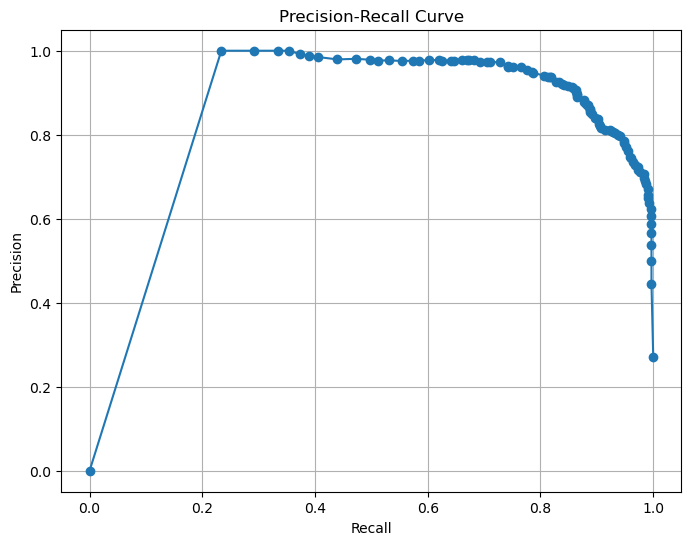

In [35]:

from sklearn.metrics import precision_score, recall_score

# Initialize empty lists to store precision and recall values
precision_values = []
recall_values = []

# Define a range of thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Iterate through each threshold
for threshold in thresholds:
    # Predict binary labels based on the threshold
    y_valid_pred_binary = (y_valid_pred_proba >= threshold).astype(int)
    
    # Calculate precision and recall for the current threshold
    precision = precision_score(y_valid, y_valid_pred_binary)
    recall = recall_score(y_valid, y_valid_pred_binary)
    
    # Append precision and recall values to the lists
    precision_values.append(precision)
    recall_values.append(recall)

# Create a precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, marker='o', linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()
